# **Wait Listing Based on attendance percentage, engagement levels, and behavior data for VIP and loyalty status**

<ipython-input-8-904e3d7c7abd>:181: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(schedule))


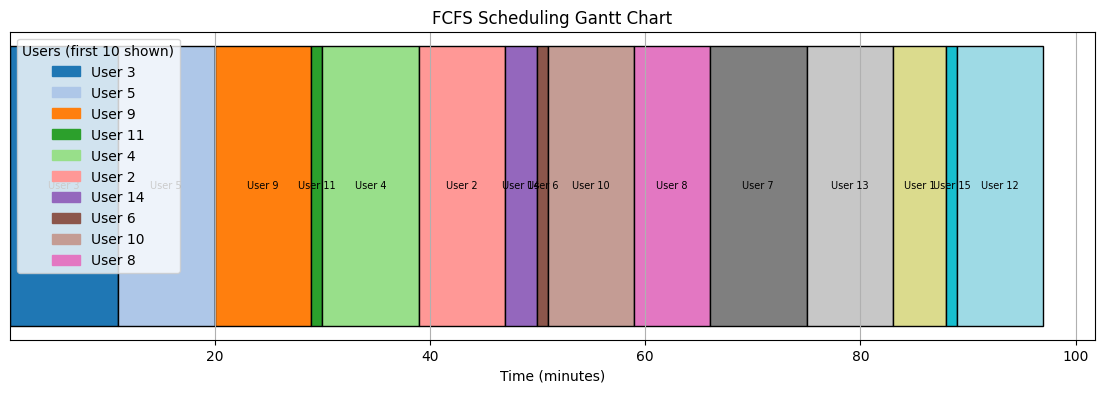

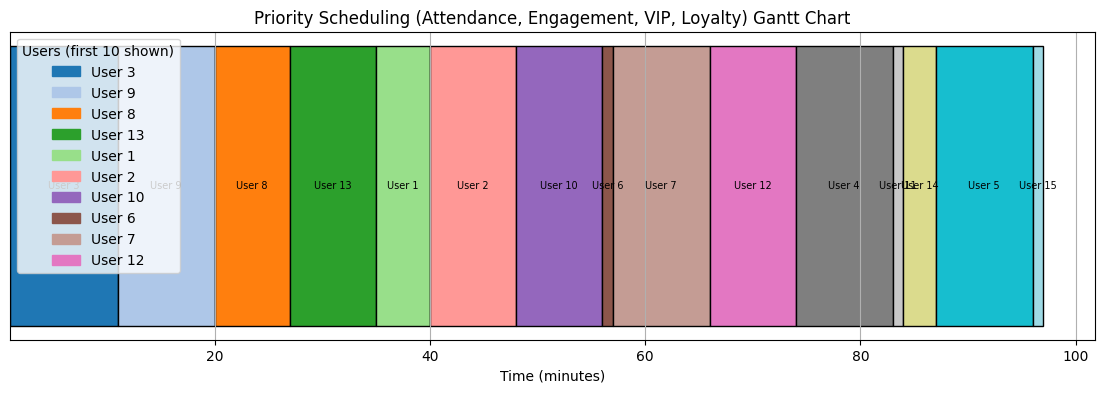

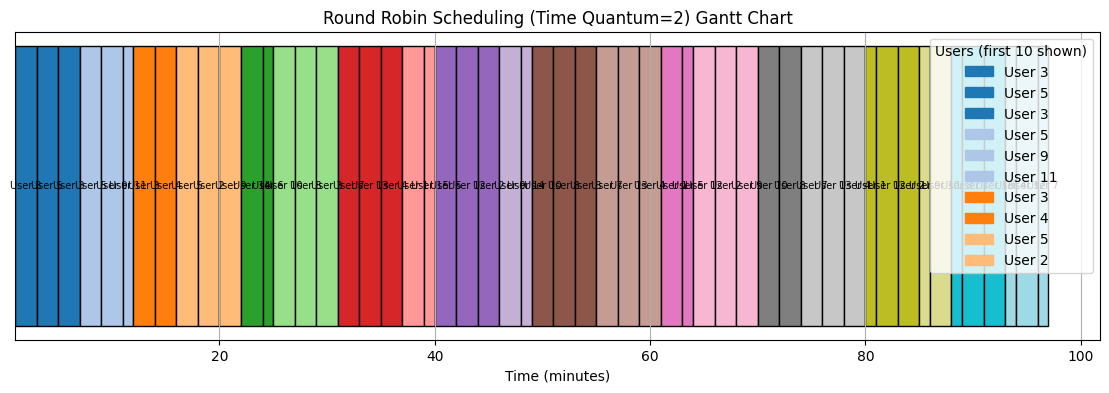

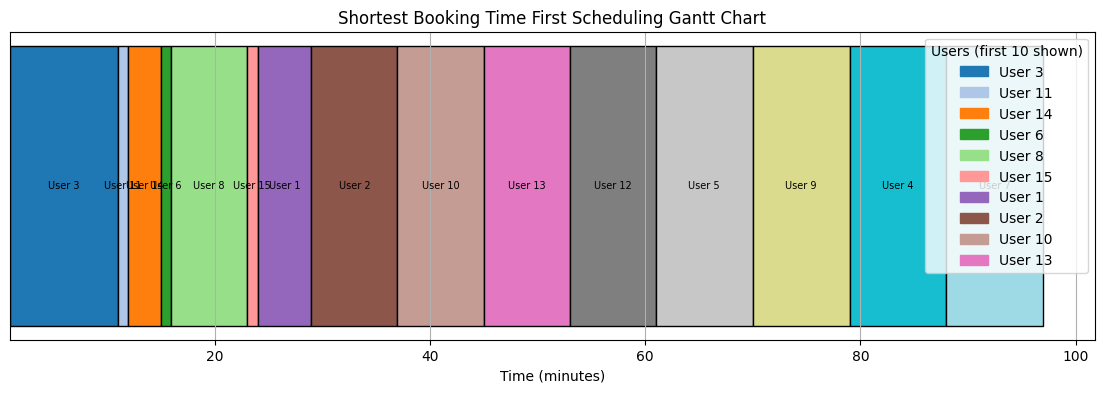

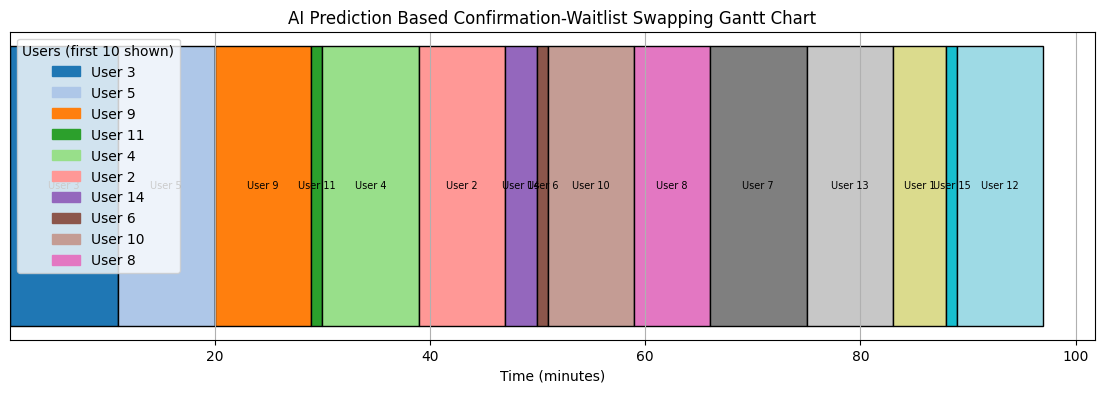

FCFS Scheduling Table (first 10 rows):
   UserID  ArrivalTime  BookingTime  AttendancePercentage  EngagementLevel  \
0       1           17            5             68.727006               20   
1       2           11            8             97.535715               32   
2       3            1           10             86.599697               75   
3       4            9            9             79.932924               57   
4       5            3            9             57.800932               21   
5       6           13            1             57.799726               88   
6       7           15            9             52.904181               48   
7       8           14            7             93.308807               90   
8       9            7            9             80.055751               58   
9      10           13            8             85.403629               41   

   VIPStatus  LoyaltyScore  CompletionTime  TurnAroundTime  WaitingTime  
0       True            59  

In [8]:
import numpy as np
import pandas as pd
import heapq
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


np.random.seed(42)
num_users = 15
attendance_percentage = np.random.uniform(50, 100, size=num_users)
engagement_levels = np.random.randint(0, 101, size=num_users)
vip_status = np.random.choice([True, False], size=num_users, p=[0.2, 0.8])
loyalty_score = np.random.randint(0, 101, size=num_users)
arrival_time = np.random.randint(0, 21, size=num_users)
booking_time = np.random.randint(1, 11, size=num_users)

users_df = pd.DataFrame({
    'UserID': range(1, num_users+1),
    'AttendancePercentage': attendance_percentage,
    'EngagementLevel': engagement_levels,
    'VIPStatus': vip_status,
    'LoyaltyScore': loyalty_score,
    'ArrivalTime': arrival_time,
    'BookingTime': booking_time
})


users_df['PriorityScore'] = (
    users_df['AttendancePercentage'] * 0.4 +
    users_df['EngagementLevel'] * 0.3 +
    users_df['VIPStatus'].astype(int) * 20 +
    users_df['LoyaltyScore'] * 0.3
)



def fcfs_scheduling(users):
    users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
    start_time = 0
    schedule = []
    for _, row in users_sorted.iterrows():
        if start_time < row['ArrivalTime']:
            start_time = row['ArrivalTime']
        finish_time = start_time + row['BookingTime']
        schedule.append((row['UserID'], start_time, finish_time))
        start_time = finish_time
    return schedule

def priority_scheduling(users):
    n = len(users)
    completed = 0
    current_time = 0
    schedule = []
    ready_queue = []
    i = 0
    users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
    while completed < n:
        while i < n and users_sorted.loc[i, 'ArrivalTime'] <= current_time:
            heapq.heappush(ready_queue, (-users_sorted.loc[i, 'PriorityScore'], users_sorted.loc[i, 'ArrivalTime'], users_sorted.loc[i, 'UserID'], users_sorted.loc[i, 'BookingTime']))
            i += 1
        if ready_queue:
            priority, arrival, user_id, burst = heapq.heappop(ready_queue)
            start_time = current_time
            finish_time = start_time + burst
            schedule.append((user_id, start_time, finish_time))
            current_time = finish_time
            completed += 1
        else:
            if i < n:
                current_time = users_sorted.loc[i, 'ArrivalTime']
            else:
                break
    return schedule

def round_robin_scheduling(users, time_quantum=2):
    users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
    n = len(users_sorted)
    remaining_time = users_sorted['BookingTime'].tolist()
    arrival_time = users_sorted['ArrivalTime'].tolist()
    user_ids = users_sorted['UserID'].tolist()
    current_time = 0
    schedule = []
    queue = []
    i = 0
    completed = 0
    while completed < n:
        while i < n and arrival_time[i] <= current_time:
            queue.append(i)
            i += 1
        if not queue:
            if i < n:
                current_time = arrival_time[i]
                continue
            else:
                break
        idx = queue.pop(0)
        start_time = current_time
        exec_time = min(time_quantum, remaining_time[idx])
        remaining_time[idx] -= exec_time
        current_time += exec_time
        finish_time = current_time
        schedule.append((user_ids[idx], start_time, finish_time))
        while i < n and arrival_time[i] <= current_time:
            queue.append(i)
            i += 1
        if remaining_time[idx] > 0:
            queue.append(idx)
        else:
            completed += 1
    return schedule

def shortest_booking_time_first(users):
    users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
    n = len(users_sorted)
    completed = 0
    current_time = 0
    schedule = []
    ready_queue = []
    i = 0
    while completed < n:
        while i < n and users_sorted.loc[i, 'ArrivalTime'] <= current_time:
            heapq.heappush(ready_queue, (users_sorted.loc[i, 'BookingTime'], users_sorted.loc[i, 'ArrivalTime'], users_sorted.loc[i, 'UserID']))
            i += 1
        if ready_queue:
            burst, arrival, user_id = heapq.heappop(ready_queue)
            start_time = current_time
            finish_time = start_time + burst
            schedule.append((user_id, start_time, finish_time))
            current_time = finish_time
            completed += 1
        else:
            if i < n:
                current_time = users_sorted.loc[i, 'ArrivalTime']
            else:
                break
    return schedule

def ai_swap_confirmation_waitlist(users, confirmation_limit=50):
    users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
    confirmation_list = users_sorted.iloc[:confirmation_limit].copy()
    waiting_list = users_sorted.iloc[confirmation_limit:].copy()


    waiting_sorted = waiting_list.sort_values(by='PriorityScore', ascending=False)
    confirmation_sorted = confirmation_list.sort_values(by='PriorityScore')

    swaps = []
    for idx_wait, wait_row in waiting_sorted.iterrows():
        for idx_conf, conf_row in confirmation_sorted.iterrows():
            if wait_row['PriorityScore'] > conf_row['PriorityScore']:
                confirmation_list.loc[idx_conf], waiting_list.loc[idx_wait] = waiting_list.loc[idx_wait].copy(), confirmation_list.loc[idx_conf].copy()
                swaps.append((conf_row['UserID'], wait_row['UserID']))
                confirmation_sorted = confirmation_list.sort_values(by='PriorityScore')
                waiting_sorted = waiting_list.sort_values(by='PriorityScore', ascending=False)
                break

    confirmation_schedule = fcfs_scheduling(confirmation_list)
    last_finish = max([finish for _, _, finish in confirmation_schedule]) if confirmation_schedule else 0
    waiting_schedule = []
    start_time = last_finish
    for _, row in waiting_list.iterrows():
        if start_time < row['ArrivalTime']:
            start_time = row['ArrivalTime']
        finish_time = start_time + row['BookingTime']
        waiting_schedule.append((row['UserID'], start_time, finish_time))
        start_time = finish_time

    full_schedule = confirmation_schedule + waiting_schedule
    return full_schedule, swaps


fcfs_schedule = fcfs_scheduling(users_df)
priority_schedule = priority_scheduling(users_df)
rr_schedule = round_robin_scheduling(users_df, time_quantum=2)
sjf_schedule = shortest_booking_time_first(users_df)
ai_schedule, ai_swaps = ai_swap_confirmation_waitlist(users_df, confirmation_limit=50)


def plot_gantt_chart(schedule, title):
    fig, ax = plt.subplots(figsize=(14, 4))
    colors = plt.cm.get_cmap('tab20', len(schedule))
    for i, (user_id, start, finish) in enumerate(schedule):
        ax.barh(y=1, width=finish-start, left=start, height=0.3, color=colors(i), edgecolor='black')
        ax.text(x=start + (finish-start)/2, y=1, s=f'User {user_id}', va='center', ha='center', color='black', fontsize=7)
    ax.set_xlabel('Time (minutes)')
    ax.set_yticks([])
    ax.set_title(title)
    ax.grid(True, axis='x')
    patches = [mpatches.Patch(color=colors(i), label=f'User {user_id}') for i, (user_id, _, _) in enumerate(schedule)]
    ax.legend(handles=patches[:10], title='Users (first 10 shown)')
    plt.show()

plot_gantt_chart(fcfs_schedule, 'FCFS Scheduling Gantt Chart')
plot_gantt_chart(priority_schedule, 'Priority Scheduling (Attendance, Engagement, VIP, Loyalty) Gantt Chart')
plot_gantt_chart(rr_schedule, 'Round Robin Scheduling (Time Quantum=2) Gantt Chart')
plot_gantt_chart(sjf_schedule, 'Shortest Booking Time First Scheduling Gantt Chart')
plot_gantt_chart(ai_schedule, 'AI Prediction Based Confirmation-Waitlist Swapping Gantt Chart')


def generate_schedule_table(users, schedule):
    schedule_df = pd.DataFrame(schedule, columns=['UserID', 'StartTime', 'FinishTime'])
    merged = pd.merge(users, schedule_df, on='UserID')
    merged['CompletionTime'] = merged['FinishTime']
    merged['TurnAroundTime'] = merged['CompletionTime'] - merged['ArrivalTime']
    merged['WaitingTime'] = merged['TurnAroundTime'] - merged['BookingTime']
    return merged[['UserID', 'ArrivalTime', 'BookingTime', 'AttendancePercentage', 'EngagementLevel', 'VIPStatus', 'LoyaltyScore', 'CompletionTime', 'TurnAroundTime', 'WaitingTime']]

fcfs_table = generate_schedule_table(users_df, fcfs_schedule)
priority_table = generate_schedule_table(users_df, priority_schedule)
rr_table = generate_schedule_table(users_df, rr_schedule)
sjf_table = generate_schedule_table(users_df, sjf_schedule)
ai_table = generate_schedule_table(users_df, ai_schedule)

print("FCFS Scheduling Table (first 10 rows):")
print(fcfs_table.head(10))

print("\nPriority Scheduling Table (first 10 rows):")
print(priority_table.head(10))

print("\nShortest Booking Time First Scheduling Table (first 10 rows):")
print(sjf_table.head(10))

print("\nAI Prediction Based Scheduling Table (first 10 rows):")
print(ai_table.head(10))

print("\nAI-based swaps between confirmation and waitlist (UserID swapped):")
print(ai_swaps[:10])


# **Wait Listing with Scheduling Algorithms FCFS, RR, Priority Scheduling, Shortest Booking Time**

<ipython-input-4-dc62b2386637>:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(schedule))


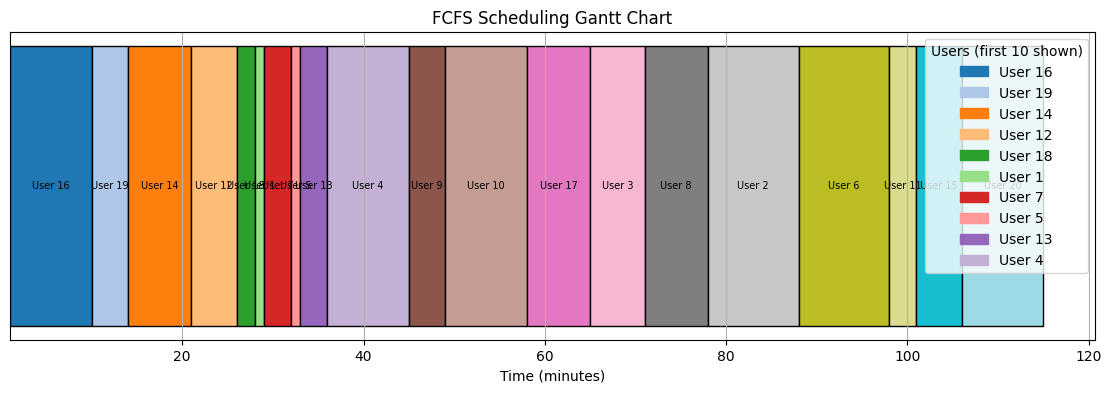

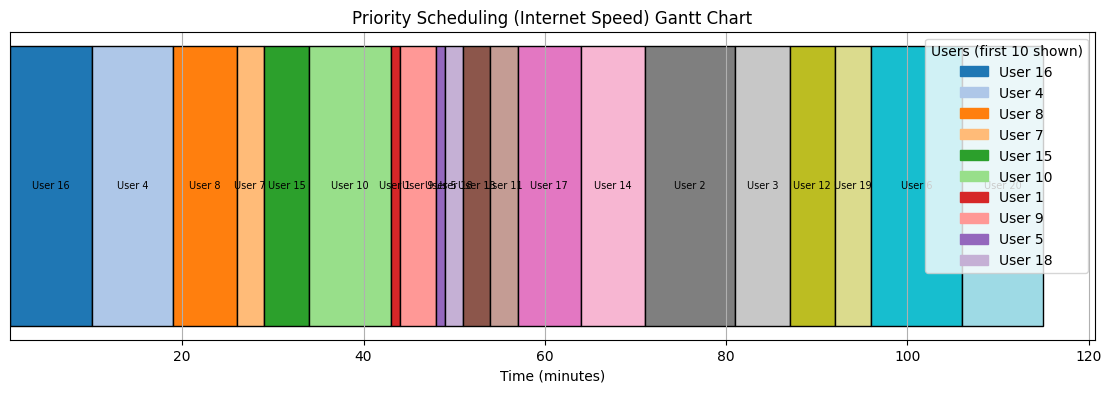

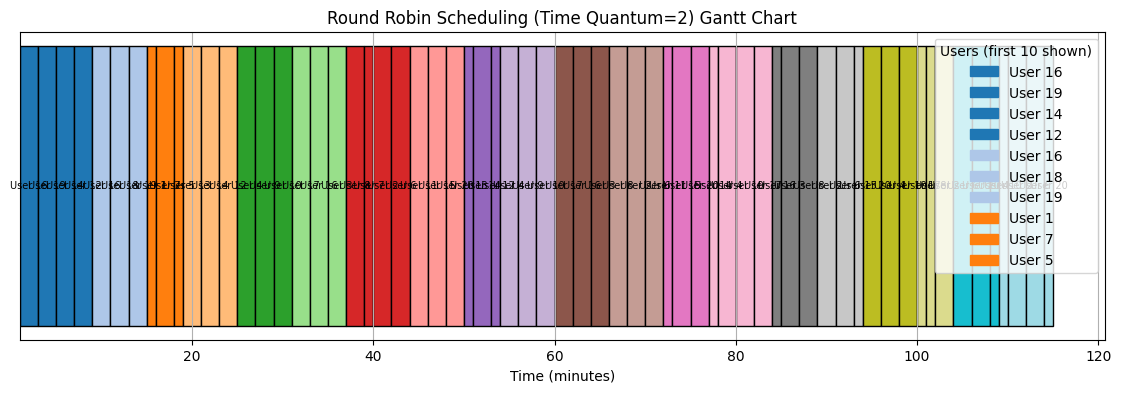

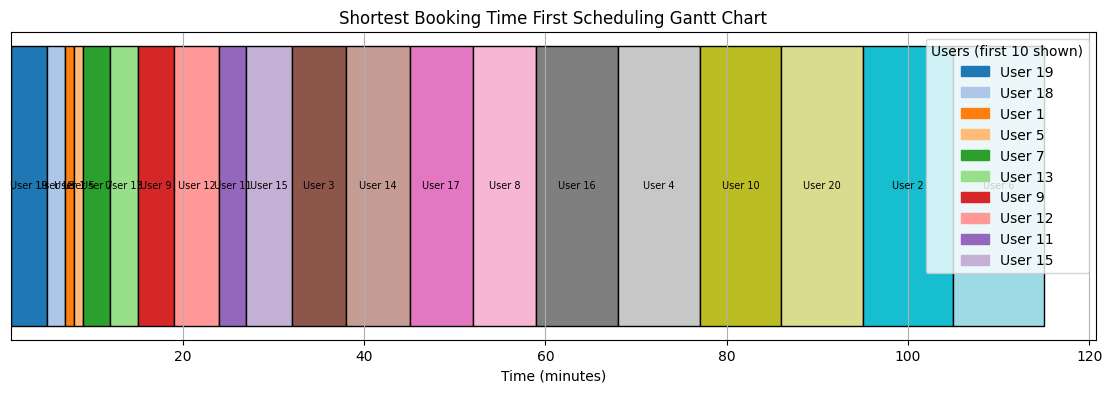

FCFS Table: 
   UserID  ArrivalTime  BookingTime  InternetSpeed  CompletionTime  \
0       1            6            1             60              29   
1       2           19           10             14              88   
2       3           14            6              9              71   
3       4           10            9             90              45   
4       5            7            1             53              33   
5       6           20           10              2              98   
6       7            6            3             84              32   
7       8           18            7             92              78   
8       9           10            4             60              49   
9      10           10            9             71              58   

   TurnAroundTime  WaitingTime  
0              23           22  
1              69           59  
2              57           51  
3              35           26  
4              26           25  
5              78 

In [4]:
import numpy as np
import pandas as pd
import heapq
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


np.random.seed(42)
num_users = 20
arrival_time = np.random.randint(0, 21, size=num_users)
booking_time = np.random.randint(1, 11, size=num_users)
internet_speed = np.random.randint(1, 101, size=num_users)

users_df = pd.DataFrame({
    'UserID': range(1, num_users+1),
    'ArrivalTime': arrival_time,
    'BookingTime': booking_time,
    'InternetSpeed': internet_speed
})



def fcfs_scheduling(users):
    users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
    start_time = 0
    schedule = []
    for _, row in users_sorted.iterrows():
        if start_time < row['ArrivalTime']:
            start_time = row['ArrivalTime']
        finish_time = start_time + row['BookingTime']
        schedule.append((row['UserID'], start_time, finish_time))
        start_time = finish_time
    return schedule

def priority_scheduling(users):
    users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
    n = len(users_sorted)
    completed = 0
    current_time = 0
    schedule = []
    ready_queue = []
    i = 0
    while completed < n:
        while i < n and users_sorted.loc[i, 'ArrivalTime'] <= current_time:
            heapq.heappush(ready_queue, (-users_sorted.loc[i, 'InternetSpeed'], users_sorted.loc[i, 'ArrivalTime'], users_sorted.loc[i, 'UserID'], users_sorted.loc[i, 'BookingTime']))
            i += 1
        if ready_queue:
            speed, arrival, user_id, burst = heapq.heappop(ready_queue)
            start_time = current_time
            finish_time = start_time + burst
            schedule.append((user_id, start_time, finish_time))
            current_time = finish_time
            completed += 1
        else:
            if i < n:
                current_time = users_sorted.loc[i, 'ArrivalTime']
            else:
                break
    return schedule

def round_robin_scheduling(users, time_quantum=2):
    users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
    n = len(users_sorted)
    remaining_time = users_sorted['BookingTime'].tolist()
    arrival_time = users_sorted['ArrivalTime'].tolist()
    user_ids = users_sorted['UserID'].tolist()
    current_time = 0
    schedule = []
    queue = []
    i = 0
    completed = 0
    while completed < n:
        while i < n and arrival_time[i] <= current_time:
            queue.append(i)
            i += 1
        if not queue:
            if i < n:
                current_time = arrival_time[i]
                continue
            else:
                break
        idx = queue.pop(0)
        start_time = current_time
        exec_time = min(time_quantum, remaining_time[idx])
        remaining_time[idx] -= exec_time
        current_time += exec_time
        finish_time = current_time
        schedule.append((user_ids[idx], start_time, finish_time))
        while i < n and arrival_time[i] <= current_time:
            queue.append(i)
            i += 1
        if remaining_time[idx] > 0:
            queue.append(idx)
        else:
            completed += 1
    return schedule

def shortest_booking_time_first(users):
    users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
    n = len(users_sorted)
    completed = 0
    current_time = 0
    schedule = []
    ready_queue = []
    i = 0
    while completed < n:
        while i < n and users_sorted.loc[i, 'ArrivalTime'] <= current_time:
            heapq.heappush(ready_queue, (users_sorted.loc[i, 'BookingTime'], users_sorted.loc[i, 'ArrivalTime'], users_sorted.loc[i, 'UserID']))
            i += 1
        if ready_queue:
            burst, arrival, user_id = heapq.heappop(ready_queue)
            start_time = current_time
            finish_time = start_time + burst
            schedule.append((user_id, start_time, finish_time))
            current_time = finish_time
            completed += 1
        else:
            if i < n:
                current_time = users_sorted.loc[i, 'ArrivalTime']
            else:
                break
    return schedule


fcfs_schedule = fcfs_scheduling(users_df)
priority_schedule = priority_scheduling(users_df)
rr_schedule = round_robin_scheduling(users_df, time_quantum=2)
shortest_schedule = shortest_booking_time_first(users_df)


def plot_gantt_chart(schedule, title):
    fig, ax = plt.subplots(figsize=(14, 4))
    colors = plt.cm.get_cmap('tab20', len(schedule))
    for i, (user_id, start, finish) in enumerate(schedule):
        ax.barh(y=1, width=finish-start, left=start, height=0.3, color=colors(i), edgecolor='black')
        ax.text(x=start + (finish-start)/2, y=1, s=f'User {user_id}', va='center', ha='center', color='black', fontsize=7)
    ax.set_xlabel('Time (minutes)')
    ax.set_yticks([])
    ax.set_title(title)
    ax.grid(True, axis='x')
    patches = [mpatches.Patch(color=colors(i), label=f'User {user_id}') for i, (user_id, _, _) in enumerate(schedule)]
    ax.legend(handles=patches[:10], title='Users (first 10 shown)')
    plt.show()


plot_gantt_chart(fcfs_schedule, 'FCFS Scheduling Gantt Chart')
plot_gantt_chart(priority_schedule, 'Priority Scheduling (Internet Speed) Gantt Chart')
plot_gantt_chart(rr_schedule, 'Round Robin Scheduling (Time Quantum=2) Gantt Chart')
plot_gantt_chart(shortest_schedule, 'Shortest Booking Time First Scheduling Gantt Chart')


def generate_schedule_table(users, schedule):
    # users: original dataframe
    # schedule: list of tuples (UserID, start_time, finish_time)
    schedule_df = pd.DataFrame(schedule, columns=['UserID', 'StartTime', 'FinishTime'])
    merged = pd.merge(users, schedule_df, on='UserID')
    merged['CompletionTime'] = merged['FinishTime']
    merged['TurnAroundTime'] = merged['CompletionTime'] - merged['ArrivalTime']
    merged['WaitingTime'] = merged['TurnAroundTime'] - merged['BookingTime']
    return merged[['UserID', 'ArrivalTime', 'BookingTime', 'InternetSpeed', 'CompletionTime', 'TurnAroundTime', 'WaitingTime']]


fcfs_table = generate_schedule_table(users_df, fcfs_schedule)
print("FCFS Table: ")
print(fcfs_table.head(10))
priority_table = generate_schedule_table(users_df, priority_schedule)
print("Priority Table: ")
print(priority_table.head(10))
rr_table = generate_schedule_table(users_df, rr_schedule)
print("Round Robin Table: ")
print(rr_table.head(10))
shortest_table = generate_schedule_table(users_df, shortest_schedule)
print("Shortest Booking Table: ")
print(shortest_table.head(10))
